
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [ ]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc

def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        all_image_batches = np.zeros(shape=(batch_size, self.num_samples_per_class, self.num_classes, self.dim_input), dtype=np.float32)
        all_label_batches = np.zeros(shape=(batch_size, self.num_samples_per_class, self.num_classes, self.num_classes), dtype=np.float32)
        

        for batch_id in range(batch_size):
            tmp = np.random.randint(0, self.num_classes)
            paths = np.random.choice(folders, self.num_classes)
            one_hot_labels = np.identity(self.num_classes)
            if batch_type == "test":
                np.random.shuffle(one_hot_labels)
                
            images_labels = get_images(paths, range(self.num_classes), nb_samples=self.num_samples_per_class, shuffle=False)
            
            sam_per_class = {}
            for i in range(self.num_classes):
                sam_per_class[i] = 0

            for idx, (label, fname) in enumerate(images_labels):                  
                img = image_file_to_array(fname, self.dim_input)
                all_image_batches[batch_id, sam_per_class[label], label, :] = img
                all_label_batches[batch_id, sam_per_class[label], label, :] = one_hot_labels[:, label]
                sam_per_class.update({label:sam_per_class[label]+1})

            
        #############################

        return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers

class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        #print('anu')
        B, K, N, D = input_images.shape
        images = tf.reshape(input_images, (B, K*N, D))
        
        # filling the last N examples with zeros
        labels = tf.concat((input_labels[:,:-1], tf.zeros_like(input_labels[:, -1:])), axis=1)
        
        # reshaping to match with images
        labels = tf.reshape(labels, (B, K*N, N))

        tmp = self.layer1(tf.concat((images, labels), axis=-1))
        tmp = self.layer2(tmp)
        out = tf.reshape(tmp, (B, K, N, N))
        #############################
        return out

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        #############################
        #### YOUR CODE GOES HERE ####
        loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(y_true=labels[:, -1, :, :], y_pred=preds[:, -1, :, :], from_logits=True))
        #############################
        return loss

@tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss


def main(num_classes=5, num_samples=1, meta_batch_size=32, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = MANN(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)

    result = dict()
    
    for step in range(25000):
        i, l = data_generator.sample_batch('train', meta_batch_size)
        _, ls = train_step(i, l, o, optim)

        if (step + 1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            i, l = data_generator.sample_batch('test', 100)
            pred, tls = train_step(i, l, o, optim, eval=True)
            print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            l = tf.math.argmax(l[:, -1, :, :], axis=2)
            print("Test Accuracy", tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy())
            result[step] = {'train_loss':ls.numpy(), 'test_loss':tls.numpy(), 'test_acc':tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy()}
            
    return result

In [ ]:
import matplotlib.pyplot as plt
results = main(num_classes=4, num_samples=2, meta_batch_size=128, random_seed=1234)
#############################
#### YOUR CODE GOES HERE ####
# pass
#############################

Text(0.5, 1.0, 'K=1, N=4')

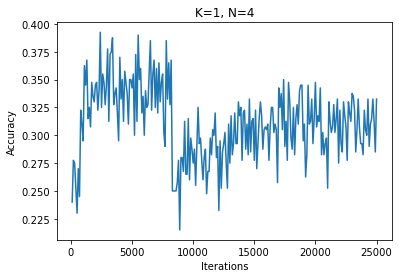

In [106]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

N=4
K=1
results = pickle.load(open("LR_N"+str(N)+"K"+str(K)+".pkl", "rb"))
itr = []
acc = []
for k, v in results.items():
    itr.append((k+1))
    acc.append(v['test_acc'])
    
plt.plot(itr, acc)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title("K={0}, N={1}".format(K, N))

In [107]:
np.mean(acc), np.std(acc), np.max(acc), np.min(acc)

(0.31108996, 0.032666296, 0.3925, 0.215)